In [1]:
import matplotlib
%matplotlib inline

from mimetypes import init
import matplotlib as mpl
label_size = 8
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

import jax
import jax.numpy as jnp                # JAX NumPy
from jax.scipy.special import logsumexp
import numpy as np  
import matplotlib.pyplot as plt

from scipy.optimize import minimize
import corner
import tqdm
import time
import pickle
import os

from flowMC.nfmodel.realNVP import RealNVP
from flowMC.sampler.MALA import mala_sampler
from flowMC.nfmodel.utils import *
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys


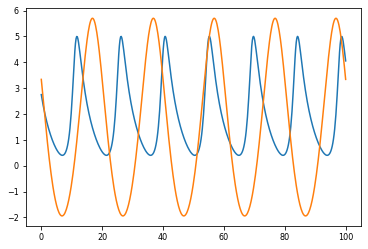

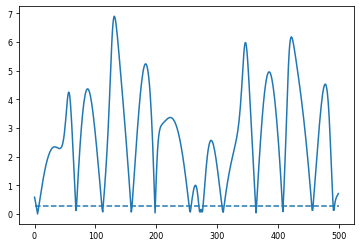

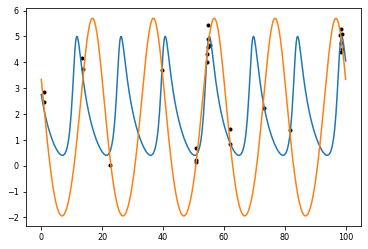

In [27]:

from utils import rv_model, log_likelihood, log_prior, sample_prior, get_kepler_params_and_log_jac
from plot import draw_corner, draw_kepler_results, draw_corner_nf

if os.path.isdir('/mnt/ceph/users/mgabrie/'):
    ceph_home = '/mnt/ceph/users/mgabrie/nfsampler/'
elif os.path.isdir('/Users/marylou/Dropbox/Postdoc/Experiments/ceph/nfsampler/'):
    ceph_home = '/Users/marylou/Dropbox/Postdoc/Experiments/ceph/nfsampler/'
elif os.path.isdir('/mnt/beegfs/workdir/marylou.gabrie'):
    ceph_home = '/mnt/beegfs/workdir/marylou.gabrie/flowmc/'
else:
    raise RuntimeError('Data path not understood')

jax.config.update("jax_enable_x64", True)

## Generate probelm
true_params = jnp.array([
    2.0, # v0
    np.log(0.5), # log_s2
    np.log(14.5), # log_P 
    np.log(2.3), # log_k
    np.sin(1.5), # phi
    np.cos(1.5),
    0.4, # ecc
    np.sin(-0.7), # w
    np.cos(-0.7)
])

true_params_2 = jnp.array([
    1.5, # v0
    np.log(0.5), # log_s2
    np.log(20), # log_P 
    np.log(4), # log_k
    np.sin(1), # phi
    np.cos(1),
    0.1, # ecc
    np.sin(0.), # w
    np.cos(0.3)
])


n_obs = 25

# random = np.random.default_rng(12345)
rv_err = 0.3
sigma2 = rv_err ** 2 + jnp.exp(2 * true_params[1])

ts = np.linspace(0, 100, 500)
rv1 = rv_model(true_params, ts)
rv2 = rv_model(true_params_2, ts)


plt.plot(ts, rv1, "C0")
plt.plot(ts, rv2, "C1")
plt.show(block=False)

plt.figure()
plt.plot(np.abs(rv1 - rv2) )
plt.hlines(rv_err, 0, 500, linestyles='--')

random = np.random.default_rng(1245)
t_obs = np.sort(np.random.choice(ts[np.abs(rv1 - rv2) < np.sqrt(sigma2)], n_obs))
rv_obs = rv_model(true_params, t_obs) + random.normal(0, sigma2, len(t_obs))
plt.figure()
plt.plot(t_obs, rv_obs, ".k")
plt.plot(ts, rv1, "C0")
plt.plot(ts, rv2, "C1")
plt.show(block=False)

In [ ]:
# prior_kwargs = { ## peaked
#     'ecc_alpha': 2, 'ecc_beta': 2,
#     'log_k_mean': 1, 'log_k_var': 1,
#     'v0_mean': 10, 'v0_var': 2,
#     'log_period_mean': 2.5, 'log_period_var': 2,
#     'log_s2_mean': -0.5, 'log_s2_var': 0.1,
# }

prior_kwargs = { ## flatter
    'ecc_alpha': 2, 'ecc_beta': 2,
    'log_k_mean': 1, 'log_k_var': 5,
    'v0_mean': 0, 'v0_var': 10,
    'log_period_mean': 1, 'log_period_var': 5,
    'log_s2_mean': -0.5, 'log_s2_var': 0.1,
}